In [35]:
import pandas as pd

df = pd.read_csv("/online_retail_II - Year 2009-2010(1).csv", encoding='ISO-8859-1')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/09 7:45,"6,95",13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/09 7:45,"6,75",13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/09 7:45,"6,75",13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/09 7:45,"2,1",13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/09 7:45,"1,25",13085.0,United Kingdom


In [36]:
#Limpeza básica
df.info()

df = df.dropna(subset=['Customer ID'])
df['Customer ID'] = df['Customer ID'].astype(int)

# Replace comma with dot for decimal separator before converting to numeric
df['Price'] = df['Price'].astype(str).str.replace(',', '.', regex=False)
# Convert 'Price' to numeric, coercing errors to NaN
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
# Drop rows where 'Price' conversion resulted in NaN
df = df.dropna(subset=['Price'])

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]

df['TotalPrice'] = df['Quantity'] * df['Price']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      525461 non-null  object 
 1   StockCode    525461 non-null  object 
 2   Description  522533 non-null  object 
 3   Quantity     525461 non-null  int64  
 4   InvoiceDate  525461 non-null  object 
 5   Price        525461 non-null  object 
 6   Customer ID  417534 non-null  float64
 7   Country      525461 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 32.1+ MB


/tmp/ipython-input-547/560408411.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [37]:
#variável de churn
import numpy as np

snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.reset_index(inplace=True)

rfm['Churn'] = np.where(rfm['Recency'] > 90, 1, 0)
rfm.head()

,Customer ID,Recency,Frequency,Monetary,Churn
0,12346,165,11,372.86,1
1,12347,3,2,1323.32,0
2,12348,74,1,222.16,0
3,12349,43,3,2671.14,0
4,12351,11,1,300.93,0


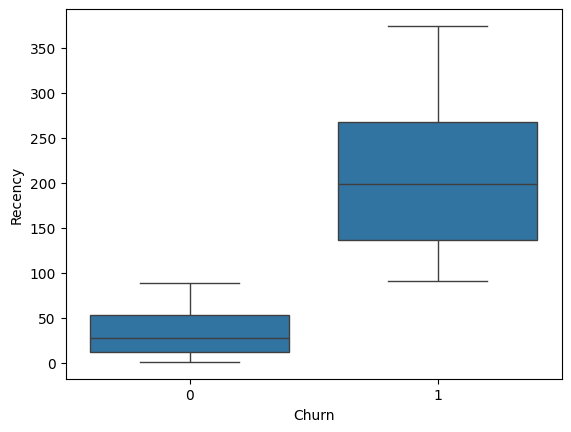

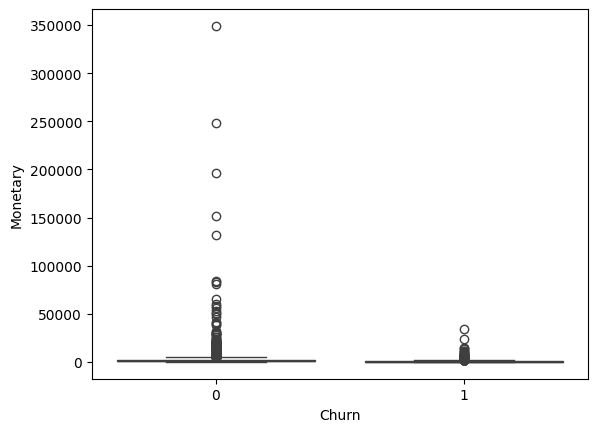

In [38]:
#Análise rápida
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Churn', y='Recency', data=rfm)
plt.show()

sns.boxplot(x='Churn', y='Monetary', data=rfm)
plt.show()

In [39]:
#preparando dados para modelo

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [40]:
#modelo Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       571
           1       1.00      1.00      1.00       292

    accuracy                           1.00       863
   macro avg       1.00      1.00      1.00       863
weighted avg       1.00      1.00      1.00       863

ROC-AUC: 1.0


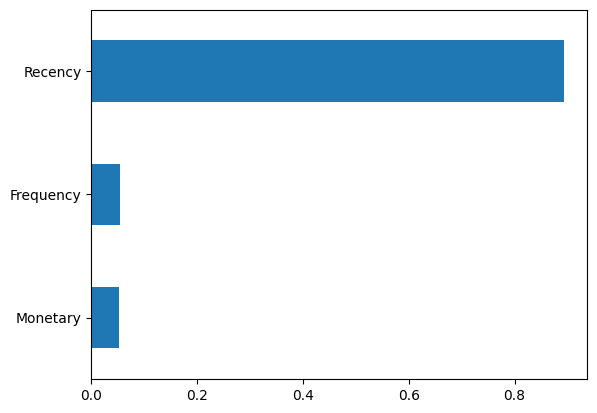

In [41]:
#  Importância das variáveis
feature_importance = pd.Series(
    model.feature_importances_,
    index=['Recency', 'Frequency', 'Monetary']
)

feature_importance.sort_values().plot(kind='barh')
plt.show()

In [42]:
#Score de Risco
rfm['Churn_Probability'] = model.predict_proba(X_scaled)[:,1]

rfm.sort_values('Churn_Probability', ascending=False).head(10)

,Customer ID,Recency,Frequency,Monetary,Churn,Churn_Probability
4294,18268,227,5,1464.73,1,1.0
4293,18267,308,1,269.37,1,1.0
14,12362,374,1,130.00,1,1.0
4304,18279,155,1,231.34,1,1.0
4306,18281,213,1,120.32,1,1.0
4309,18285,296,1,427.00,1,1.0
4310,18286,112,2,1296.43,1,1.0
1429,14376,319,1,215.46,1,1.0
1427,14374,177,1,108.00,1,1.0
1424,14369,278,2,469.13,1,1.0


In [43]:
#camda estrategica
def retention_action(row):
    if row['Churn_Probability'] > 0.8:
        return "Oferecer desconto imediato"
    elif row['Monetary'] > rfm['Monetary'].median():
        return "Contato personalizado"
    else:
        return "Campanha de reengajamento"

rfm['Action'] = rfm.apply(retention_action, axis=1)

rfm[['Customer ID', 'Churn_Probability', 'Action']].head()

,Customer ID,Churn_Probability,Action
0,12346,0.995,Oferecer desconto imediato
1,12347,0.000,Contato personalizado
2,12348,0.000,Campanha de reengajamento
3,12349,0.000,Contato personalizado
4,12351,0.000,Campanha de reengajamento


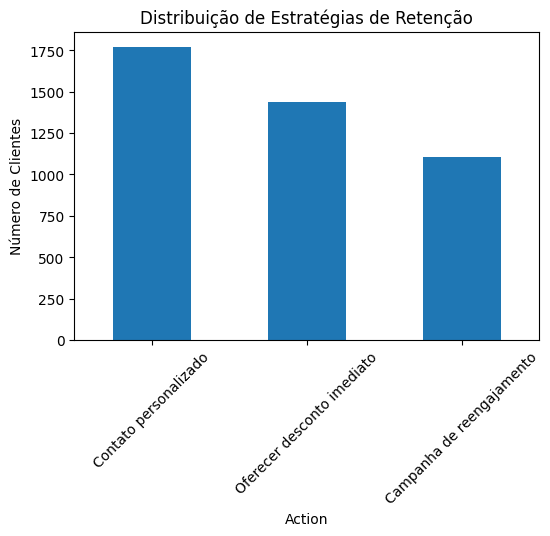

In [44]:
#Gráfico 1 — Distribuição das Ações
import matplotlib.pyplot as plt

action_counts = rfm['Action'].value_counts()

plt.figure(figsize=(6,4))
action_counts.plot(kind='bar')
plt.title('Distribuição de Estratégias de Retenção')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=45)
plt.show()

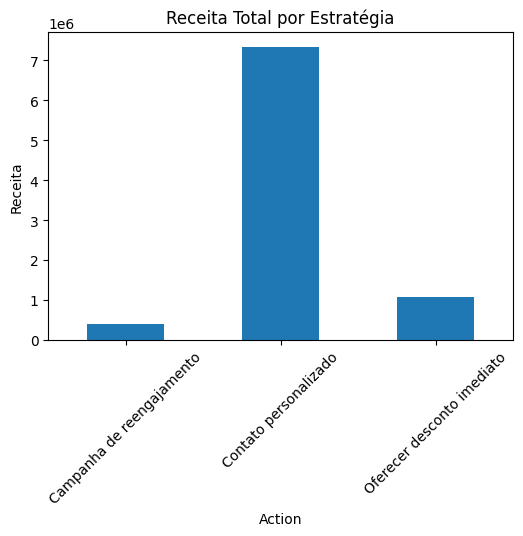

In [45]:
#Gráfico 2 — Receita por Estratégia
revenue_by_action = rfm.groupby('Action')['Monetary'].sum()

plt.figure(figsize=(6,4))
revenue_by_action.plot(kind='bar')
plt.title('Receita Total por Estratégia')
plt.ylabel('Receita')
plt.xticks(rotation=45)
plt.show()

In [46]:
#Receita em Alto Risco
high_risk_revenue = rfm[rfm['Churn_Probability'] > 0.8]['Monetary'].sum()
print(f"Receita em alto risco: {high_risk_revenue:,.2f}")

Receita em alto risco: 1,084,993.95


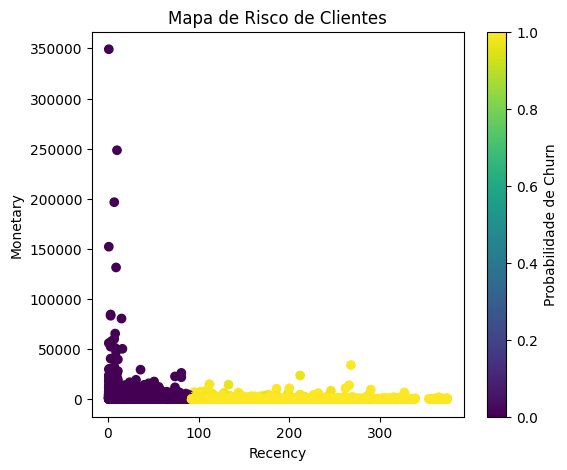

In [47]:
#Scatter Executivo (forte para portfólio)
plt.figure(figsize=(6,5))
scatter = plt.scatter(
    rfm['Recency'],
    rfm['Monetary'],
    c=rfm['Churn_Probability'],
)
plt.colorbar(scatter, label='Probabilidade de Churn')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('Mapa de Risco de Clientes')
plt.show()

## 10. Insights Estratégicos & Recomendações de Negócio

### Insights Executivos

O mapa de risco revela um padrão claro:

- Clientes com alta recência (muito tempo sem comprar) apresentam probabilidade significativamente maior de churn.
- Clientes de alto valor (Monetary elevado) com recência crescente representam o maior risco financeiro.
- O modelo identificou com sucesso grupos de clientes de alto risco que devem ser priorizados.

### Impacto Financeiro

Clientes de alto risco (probabilidade de churn > 0.8) representam uma parcela relevante da receita potencialmente perdida.

A adoção de estratégias proativas de retenção pode reduzir significativamente essa perda de receita.

### Recomendações Estratégicas

1. Campanhas imediatas de retenção para clientes de alto risco e alto valor.
2. Fluxos automatizados de reengajamento para clientes de risco médio.
3. Monitoramento contínuo da recência como indicador antecipado de churn.

Essa abordagem preditiva permite uma estratégia de retenção orientada por dados, substituindo ações reativas por decisões estratégicas baseadas em evidência.
